In [34]:
import sys

In [35]:
!{sys.executable} -m pip install scikit-image lime


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries 
import lime
from lime import lime_image
import json
import requests

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA : {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPU")

CUDA : NVIDIA GeForce RTX 5080


In [37]:

def get_imagenet_class_names():
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    class_names = requests.get(url).text.split('\n')
    return class_names

IMAGENET_CLASSES = get_imagenet_class_names()

In [38]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()


img_path = 'data/classic_car.jpg' 
img = Image.open(img_path).convert("RGB")
img_numpy = np.array(img.resize((224, 224)))

In [39]:
def batch_predict(images):
    """
    Wrapper function that normalizes NumPy images and returns 
    the probabilities predicted by the PyTorch model.
    
    Args:
        images (np.ndarray): Array of images (Batch x H x W x C).
    
    Returns:
        np.ndarray: Class probabilities (Batch x N_Classes).
    """
    tensor_batch = torch.stack([transforms.ToTensor()(Image.fromarray(image)).to(torch.float32) for image in images]).to(device)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    normalized_batch = (tensor_batch - mean) / std
    with torch.no_grad():
        logits = model(normalized_batch)
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    return probs

100%|██████████| 10000/10000 [00:17<00:00, 571.77it/s]


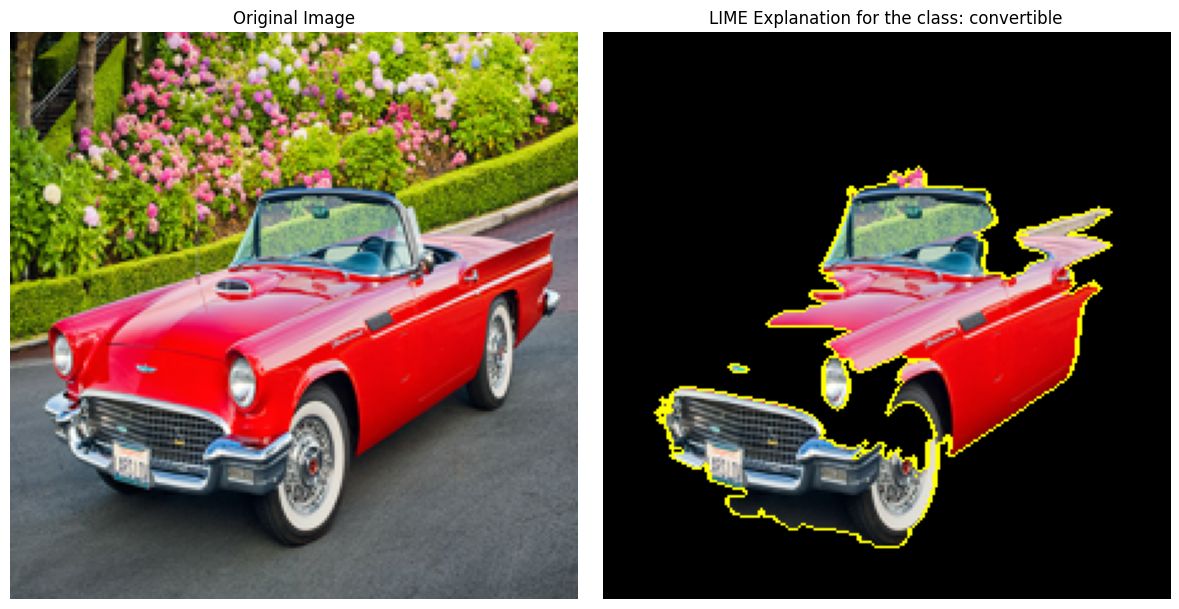

In [ ]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    img_numpy, 
    batch_predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=10000
)

temp_output = batch_predict(img_numpy[np.newaxis, ...]) #adding the batch dimension: H,W,C => 1,H,W,C
predicted_class_idx = np.argmax(temp_output[0])
predicted_class_name = IMAGENET_CLASSES[predicted_class_idx]
temp, mask = explanation.get_image_and_mask(
    predicted_class_idx, 
    positive_only=True, 
    num_features=7, 
    hide_rest=True
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
ax1.imshow(img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(mark_boundaries(temp / 255.0, mask))
ax2.set_title(f"LIME explanation for the class: {predicted_class_name}")
ax2.axis('off')

plt.tight_layout() 
plt.show()